# Two layer network on winconsi breast cancer dataset
    Experimenting with breast cancer dataset to get intuition on how neural net work and things that affect the neural in prediction accuracy

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Two layer network using sgd
class TwoLayer(object):
    
    def __init__(self,input_size,hidden_size,output_size,std=1e-4):
        
        self.params = {}
        self.params["w1"] = std * np.random.randn(input_size,hidden_size)
        self.params["w2"] = std * np.random.randn(hidden_size,output_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["b2"] = np.zeros(output_size)
        
    def loss(self,x,y=None,reg=0.0):
        
        w1,w2 = self.params["w1"], self.params["w2"]
        b1,b2 = self.params["b1"], self.params["b2"]
        
        N,_  = x.shape
        loss = None
        layer = x.dot(w1) + b1
        layer[layer <0] = 0 #relu 
        score = layer.dot(w2) + b2
        
        if y is None:
            return score
        
        #compute log(exp(fyi)/sum(exp(fyj)))
        #0r fyi - log(sum(exp(fyj)))
        stable_score = (score - np.max(score)).T
        
        fyi = stable_score[y,range(N)]
        fyj = np.exp(stable_score)
        
        
        li = -fyi +  np.log(np.sum(fyj,axis=0))
        
        mul_li = np.mean(li)
        Reg_li = 0.5*reg*(np.sum(w1*w1) + np.sum(w2*w2))
        
        loss = mul_li + Reg_li
        
        grads = {}
        
        dfj = (np.exp(fyj)/np.sum(np.exp(fyj),axis=0))
        dfyi = np.zeros(fyj.shape)
        dfyi[y,range(N)]=1
        
        dli = (dfj - dfyi)/N
        
        db2 = dli.sum(axis=1)
        
        dw2 = dli.dot(layer).T + reg*w2
        
        dlayer = dli.T.dot(w2.T)
        
        #backprop relu
        dlayer[layer<=0] = 0
        
        db1 = dlayer.sum(axis=0)
        
        dw1 = dlayer.T.dot(x).T + reg*w1
        
        assert db1.shape==b1.shape
        assert db2.shape==b2.shape
        assert dw1.shape==w1.shape
        assert dw2.shape==w2.shape
        
        grads["w1"] =dw1
        grads["w2"] =dw2
        grads["b1"] =b1
        grads["b2"] =b2
        
        return loss ,grads
    
    def train(self,X,y,x_val=None,y_val=None,learning_rate=1e-3,
             learning_rate_decay=0.95,num_iters=100,
             batch_size=2,reg=1e-7,verbose=False):
        
        num_train = X.shape[0]
        
        iteration_per_epoch = max(num_train/batch_size,1)
        
        loss_history = []
        val_acc_history = []
        train_acc_history = []
        
        for it in xrange(num_iters):
            X_batch = None
            y_batch = None
            
            samplebatch = np.random.choice(range(num_train),batch_size,replace=True)
            X_batch = X[samplebatch,:]
            y_batch = y[samplebatch]
            
            loss,grads = self.loss(X_batch,y_batch,reg=reg)
            loss_history.append(loss)
            
            param_scale = np.linalg.norm(self.params['w1'].ravel())
            for param_name in grads:
                #update = - learning_rate * grads['w1']
                #update_scale = np.linalg.norm(update.ravel())
                self.params[param_name] -= learning_rate * grads[param_name]
                
            if verbose and it%100==0:
                print "iteration %d / %d:loss %f" %(it, num_iters,loss)
                #print update_scale/param_scale
                
            if it % iteration_per_epoch==0:
                train_acc = (self.predict(X_batch)==y_batch).mean()
                val_acc = (self.predict(x_val)==y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                
                learning_rate *=learning_rate_decay
                
        return {
                "loss_history":loss_history,
                "train_acc_history":train_acc_history,
                "val_acc_history":val_acc_history
            }
    def predict(self,x):
        
        y_pred = None
        
        y_pred = self.loss(x,y=None,reg=0.0).argmax(axis=1)
        
        return y_pred
        
        
        
        

In [23]:
#get our data which is thewincosi breast cancer dataset

data = []
label = []
with open("brc.csv","r") as fn:
    filem = fn.readlines()
    filem.pop(0)
    for f in filem:
        op = f.split(",")
        op.pop(0)
        x = []
        
        #check if index 5 of the list conatian "?"
        #then over look such a list
        if op[5] =="?":
            continue
        
        #loop through list op and convert the string to float and integer
        #to be store in the data and label
        for i in op:
            
            if i==op[len(op)-1]:
                if int(i)==2:
                    label.append(0)
                else:
                    label.append(1)
                
            else:
                
                x.append(float(int(i)))
            
        data.append(x)
            
        
#clean the data to be mean centered 

#you can comment dis out to use the non centered mean data
data -= np.mean(data,axis=0)


In [24]:
#spliting up data using scikit-learn test-split 
from sklearn.model_selection import train_test_split
X_trainp,X_test,y_trainp,y_test = train_test_split(np.array(data),np.array(label),test_size=0.25,random_state=42)

X_train,X_val,y_train,y_val = train_test_split(X_trainp,y_trainp,test_size=0.10,random_state=42)

In [25]:
"""
Try to overfit the network with small part of the data
we will use 100 sample of the the train and validation data
"""
input_size = np.size(X_train[0])
hidden_sizes = 50
num_classes = 2

toy_x = X_train[:100, :]
toy_y = y_train[:100]

val_x = X_val[:100,:]
val_y = y_val[:100]

net  = TwoLayer(input_size,hidden_sizes,num_classes)

In [26]:
stats = net.train(toy_x,toy_y,val_x,val_y,
                  batch_size=20,num_iters=1000,learning_rate=6e-3,
                 learning_rate_decay=1.0,reg=2.0,verbose=True)

val_acc = (net.predict(val_x) == y_val).mean()

print 'Validation accuracy:', val_acc

iteration 0 / 1000:loss 0.693152
iteration 100 / 1000:loss 0.693147
iteration 200 / 1000:loss 0.693147
iteration 300 / 1000:loss 0.693147
iteration 400 / 1000:loss 0.693147
iteration 500 / 1000:loss 0.693147
iteration 600 / 1000:loss 0.693147
iteration 700 / 1000:loss 0.693147
iteration 800 / 1000:loss 0.693147
iteration 900 / 1000:loss 0.693147
Validation accuracy: 0.9615384615384616


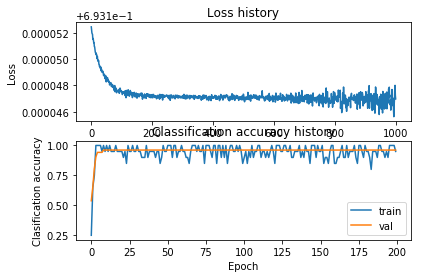

In [27]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)

plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [28]:
toy_xt = X_test[:100,:]
toy_yt = y_test[:100]
test_acc = (net.predict(toy_xt) == toy_yt).mean()
print test_acc

0.96


## Result
 we are able to see that the mean centered data produce a better test accuracy and a high validation accuracy.For this network we get a test_acc:0.96 and validation_acc:0.9615 and for non centered data we get a test_accuracy:0.32 and a validation accuracy:0.48

In [31]:
#train the network on the full dataset

net  = TwoLayer(input_size,hidden_sizes,num_classes)

stats =net.train(X_train,y_train,X_val,y_val,
                  batch_size=20,num_iters=1000,learning_rate=6e-3,
                 learning_rate_decay=1.0,reg=2.0,verbose=True)

val_acc = (net.predict(X_val) == y_val).mean()

print 'Validation accuracy:', val_acc

iteration 0 / 1000:loss 0.693153
iteration 100 / 1000:loss 0.693148
iteration 200 / 1000:loss 0.693147
iteration 300 / 1000:loss 0.693147
iteration 400 / 1000:loss 0.693147
iteration 500 / 1000:loss 0.693147
iteration 600 / 1000:loss 0.693147
iteration 700 / 1000:loss 0.693147
iteration 800 / 1000:loss 0.693147
iteration 900 / 1000:loss 0.693147
Validation accuracy: 0.9615384615384616


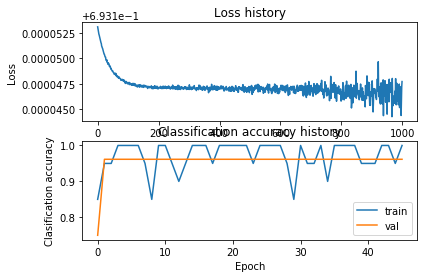

In [32]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)

plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [33]:
test_acc = (net.predict(X_test) == y_test).mean()
print test_acc

0.9766081871345029


In [43]:
x = np.array([[6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0]])
x -= np.mean(x,axis=0)
print net.predict(x)

[0]
